In [1]:
import os, glob, random, math
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")

[INFO] Using device: cuda


In [19]:
BASE_DATA_DIR = "processed_ts"           # expects train/valid/test subfolders
SAMPLES_PER_MIN = 300                    # 300 samples ~= 1 minute
WINDOW_SIZE = 1050                       # 3.5 minutes if 300 samples/min
STRIDE = WINDOW_SIZE                     # non-overlapping
TAIL_MIN_KEEP = WINDOW_SIZE // 2         # pad the last window only if tail >= 525
MIN_WAKE_DURATION_FOR_FILE_POS = SAMPLES_PER_MIN  # >= 1 minute contiguous wake => file label = 1

# Training
LR = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
EARLY_STOP_PATIENCE = 15
DECISION_THR = 0.5

In [4]:
def load_and_preprocess_data(file_path):
    """
    Load a single CSV. Expects columns: 't_s', 'z_m', 'wake_label'.
    Sorts by time and resets index.
    """
    df = pd.read_csv(file_path)
    df = df.sort_values(by="t_s").reset_index(drop=True)
    return df

In [5]:
def file_has_long_wake(df, min_len_samples=MIN_WAKE_DURATION_FOR_FILE_POS):
    """
    Returns True if the file has a contiguous wake segment (wake_label==1)
    of at least 'min_len_samples'.
    """
    w = df["wake_label"].to_numpy(dtype=np.int8)
    if w.max() == 0:
        return False
    # run-length of 1's
    best = cur = 0
    for v in w:
        if v == 1:
            cur += 1
            best = max(best, cur)
        else:
            cur = 0
    return best >= min_len_samples

In [6]:
def create_fixed_windows_scaled(df, window_size, stride, scaler=None, fit_scaler=True,
                                tail_min_keep=0):
    """
    Create non-overlapping windows. Keep full windows; for the tail:
    - If tail length >= tail_min_keep, PAD with last value to full window_size.
    - Else drop the tail.

    Returns:
      sequences: np.ndarray (N, window_size, 1) scaled z_m
      starts:    list of start indices for each window in original df
      scaler:    fitted StandardScaler (if fit_scaler=True)
    """
    window_size = int(window_size); stride = int(stride)
    z = df["z_m"].values.reshape(-1, 1)

    if fit_scaler:
        scaler = StandardScaler()
        z_scaled = scaler.fit_transform(z)
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided if fit_scaler=False.")
        z_scaled = scaler.transform(z)

    N = len(z_scaled)
    sequences, starts = [], []
    i = 0
    # full windows
    while i + window_size <= N:
        sequences.append(z_scaled[i:i+window_size])
        starts.append(i)
        i += stride

    # tail window (optional)
    if i < N:
        tail_len = N - i
        if tail_len >= tail_min_keep:
            tail = z_scaled[i:N]
            pad = np.repeat(tail[-1:], window_size - tail_len, axis=0)  # pad with last value
            sequences.append(np.vstack([tail, pad]))
            starts.append(i)
        # else: drop the tail

    if len(sequences) == 0:
        return None, [], scaler

    sequences = np.stack(sequences, axis=0)  # (Nwin, L, 1)
    return sequences, starts, scaler

In [23]:
def label_windows_min_duration(df, starts, window_size, min_len_samples):
    """
    Window label = 1 if there exists a contiguous run of wake_label==1
    of length >= min_len_samples within the window; else 0.
    """
    y = []
    w = df["wake_label"].to_numpy(dtype=np.int8)
    N = len(w)
    for s in starts:
        e = min(s + window_size, N)
        seg = w[s:e]
        best = cur = 0
        for v in seg:
            if v == 1:
                cur += 1
                if cur > best: best = cur
            else:
                cur = 0
        y.append(int(best >= min_len_samples))
    return np.asarray(y, dtype=np.int64)


In [8]:
def scan_splits(base_dir):
    splits = {"train": [], "valid": [], "test": []}
    for split in splits.keys():
        d = os.path.join(base_dir, split)
        if os.path.isdir(d):
            splits[split] = glob.glob(os.path.join(d, "*.csv"))
        else:
            print(f"[WARN] Split folder not found: {d}")
    return splits

In [25]:
def build_dataset_for_split(files, window_size, stride, scaler, fit_scaler, tail_min_keep):
    """
    Build X (N, 1, L), y (N,), trips (list of (fp, s, e)).
    """
    X_list, y_list, trips = [], [], []
    for fp in files:
        df = load_and_preprocess_data(fp)
        if df is None or len(df) < 1:
            continue
        seqs, starts, scaler = create_fixed_windows_scaled(
            df, window_size, stride, scaler, fit_scaler, tail_min_keep
        )
        if seqs is None:
            continue
        labels = label_windows_min_duration(df, 
                                            starts, 
                                            window_size, 
                                            min_len_samples=SAMPLES_PER_MIN  # 1 minute
                                           )
        # seqs: (Nw, L, 1) -> (Nw, 1, L)
        X_list.append(seqs.transpose(0, 2, 1))
        y_list.append(labels)
        for s in starts:
            e = min(s + window_size, len(df))
            trips.append((fp, int(s), int(e)))

    if not X_list:
        return None, None, None, scaler

    X = np.concatenate(X_list, axis=0).astype(np.float32)
    y = np.concatenate(y_list, axis=0).astype(np.float32)
    return X, y, trips, scaler

In [10]:
def dataset_stats_per_split(name, y):
    if y is None:
        print(f"[STATS] {name}: no samples")
        return
    y_int = y.astype(int)
    c = Counter(y_int)
    print(f"[STATS] {name}: N={len(y)} | #neg(0)={c.get(0,0)} | #pos(1)={c.get(1,0)}")


In [11]:
def compute_class_weight_pos(y):
    """
    Returns pos_weight for BCEWithLogitsLoss: n_neg / n_pos (torch scalar).
    If no positives, returns 1.0 to avoid inf.
    """
    y_int = y.astype(int)
    n_pos = int((y_int == 1).sum())
    n_neg = int((y_int == 0).sum())
    if n_pos == 0:
        return torch.tensor(1.0, dtype=torch.float32, device=device)
    return torch.tensor(n_neg / max(1, n_pos), dtype=torch.float32, device=device)

In [20]:
class LSTMWake(nn.Module):
    def __init__(self, input_size=1, hidden=128, num_layers=2, bidir=True, dropout=0.3, pool="max"):
        super().__init__()
        self.pool = pool
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden, num_layers=num_layers,
            batch_first=True, bidirectional=bidir, dropout=dropout if num_layers>1 else 0.0
        )
        out_dim = hidden * (2 if bidir else 1)
        self.head = nn.Linear(out_dim, 1)

    def forward(self, x):           # x: (B,1,L)
        x = x.transpose(1, 2)       # (B,L,1)
        h, _ = self.lstm(x)         # (B,L,H*)
        if self.pool == "max":
            h_agg = h.max(dim=1).values
        else:
            h_agg = h.mean(dim=1)
        logit = self.head(h_agg).squeeze(1)
        return logit


In [13]:
def window_metrics(y_true, y_prob, thr=DECISION_THR):
    y_pred = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return dict(Accuracy=acc, Precision=precision, Recall=recall, F1=f1,
                TP=int(tp), FP=int(fp), TN=int(tn), FN=int(fn))


In [14]:
def file_level_metrics(dataset_splits, idx_triplets, probs, thr=DECISION_THR):
    """
    Max-aggregate window probabilities per file to get a file-level prediction.
    File-level ground truth = 1 if file has contiguous wake >= 1 minute.
    """
    # 1) Per-file ground truth
    y_true_file = {}
    for split in ("train","valid","test"):
        for fp in dataset_splits.get(split, []):
            try:
                df = load_and_preprocess_data(fp)
            except Exception:
                continue
            y_true_file[fp] = int(file_has_long_wake(df))

    # 2) Aggregate probs
    by_file = defaultdict(list)
    for (fp, s, e), p in zip(idx_triplets, probs):
        by_file[fp].append(float(p))
    y_pred_file = {}
    for fp, plist in by_file.items():
        maxp = max(plist) if plist else 0.0
        y_pred_file[fp] = int(maxp >= thr)

    common = sorted(set(y_true_file.keys()) & set(y_pred_file.keys()))
    if not common:
        return dict(files=0, Accuracy=0.0, Precision=0.0, Recall=0.0, F1=0.0,
                    TP=0, FP=0, TN=0, FN=0)

    y_true = np.array([y_true_file[k] for k in common], dtype=int)
    y_pred = np.array([y_pred_file[k] for k in common], dtype=int)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return dict(files=len(common), Accuracy=acc, Precision=precision, Recall=recall, F1=f1,
                TP=int(tp), FP=int(fp), TN=int(tn), FN=int(fn))

In [26]:
dataset_splits = scan_splits(BASE_DATA_DIR)

scaler = None
X_tr, y_tr, idx_tr, scaler = build_dataset_for_split(
    dataset_splits["train"], WINDOW_SIZE, STRIDE, scaler, fit_scaler=True, tail_min_keep=TAIL_MIN_KEEP
)
X_va, y_va, idx_va, _ = build_dataset_for_split(
    dataset_splits["valid"], WINDOW_SIZE, STRIDE, scaler, fit_scaler=False, tail_min_keep=TAIL_MIN_KEEP
)
X_te, y_te, idx_te, _ = build_dataset_for_split(
    dataset_splits["test"],  WINDOW_SIZE, STRIDE, scaler, fit_scaler=False, tail_min_keep=TAIL_MIN_KEEP
)

if X_tr is None:
    raise RuntimeError("No training windows found. Check your data paths and columns.")

dataset_stats_per_split("Train", y_tr)
dataset_stats_per_split("Valid", y_va if y_va is not None else np.array([]))
dataset_stats_per_split("Test",  y_te if y_te is not None else np.array([]))

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=False
)
val_loader = None
if X_va is not None:
    val_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_va), torch.from_numpy(y_va)),
        batch_size=BATCH_SIZE, shuffle=False, drop_last=False
    )
test_loader = None
if X_te is not None:
    test_loader = DataLoader(
        TensorDataset(torch.from_numpy(X_te)),
        batch_size=BATCH_SIZE, shuffle=False, drop_last=False
    )


[STATS] Train: N=30561 | #neg(0)=18479 | #pos(1)=12082
[STATS] Valid: N=10566 | #neg(0)=6395 | #pos(1)=4171
[STATS] Test: N=18887 | #neg(0)=14721 | #pos(1)=4166


In [27]:
model = LSTMWake(hidden=128, dropout=0.3, pool="max").to(device)
pos_weight = torch.tensor(1.5, dtype=torch.float32, device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

best_val_f1 = -1.0
epochs_no_improve = 0
best_state = None

def eval_on_loader(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            prob = torch.sigmoid(logits).detach().cpu().numpy()
            yb_np = yb.numpy().astype(int)
            ys.append(yb_np)
            ps.append(prob)
    y_true = np.concatenate(ys, axis=0)
    y_prob = np.concatenate(ps, axis=0)
    return y_true, y_prob

print(f"[INFO] pos_weight={pos_weight.item():.4f}")

for epoch in range(1, EPOCHS+1):
    # ---- train ----
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = float(np.mean(train_losses))

    # ---- validate ----
    if val_loader is not None:
        model.eval()
        val_losses = []
        ys, ps = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)                         # on device
                loss = criterion(logits, yb)               # on device; same criterion as training
                val_losses.append(loss.item())

                prob = torch.sigmoid(logits).detach().cpu().numpy()
                ys.append(yb.detach().cpu().numpy())
                ps.append(prob)

        yv_true = np.concatenate(ys, axis=0).astype(int)
        yv_prob = np.concatenate(ps, axis=0)
        val_loss = float(np.mean(val_losses))
        val_metrics = window_metrics(yv_true, yv_prob, thr=DECISION_THR)
        val_f1 = val_metrics["F1"]
    else:
        val_loss, val_metrics, val_f1 = float('nan'), dict(F1=float('nan')), float('nan')

    print(f"Epoch {epoch:03d} | TrainLoss {train_loss:.4f}"
          + (f" | Val F1 {val_f1:.4f} P {val_metrics.get('Precision',0):.4f} R {val_metrics.get('Recall',0):.4f}" if val_loader else ""))

    # early stopping on val F1
    if val_loader is not None:
        if val_f1 > best_val_f1 + 1e-6:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= EARLY_STOP_PATIENCE:
                print(f"[INFO] Early stopping at epoch {epoch}. Best Val F1={best_val_f1:.4f}")
                break

# Load best (if available)
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

[INFO] pos_weight=1.5000
Epoch 001 | TrainLoss 0.7028 | Val F1 0.3669 P 0.5070 R 0.2875
Epoch 002 | TrainLoss 0.6602 | Val F1 0.2816 P 0.4991 R 0.1961
Epoch 003 | TrainLoss 0.6448 | Val F1 0.3093 P 0.5074 R 0.2225
Epoch 004 | TrainLoss 0.6099 | Val F1 0.2643 P 0.5061 R 0.1789
Epoch 005 | TrainLoss 0.6017 | Val F1 0.2913 P 0.5152 R 0.2031
Epoch 006 | TrainLoss 0.5746 | Val F1 0.3046 P 0.5262 R 0.2143
Epoch 007 | TrainLoss 0.5486 | Val F1 0.3234 P 0.5478 R 0.2294
Epoch 008 | TrainLoss 0.5208 | Val F1 0.3380 P 0.5356 R 0.2469
Epoch 009 | TrainLoss 0.5171 | Val F1 0.3521 P 0.5363 R 0.2620
Epoch 010 | TrainLoss 0.5022 | Val F1 0.3389 P 0.5516 R 0.2445
Epoch 011 | TrainLoss 0.5309 | Val F1 0.2583 P 0.5285 R 0.1709
Epoch 012 | TrainLoss 0.5120 | Val F1 0.3137 P 0.5645 R 0.2172
Epoch 013 | TrainLoss 0.4930 | Val F1 0.3229 P 0.5708 R 0.2251
Epoch 014 | TrainLoss 0.4795 | Val F1 0.3931 P 0.5820 R 0.2968
Epoch 015 | TrainLoss 0.4733 | Val F1 0.3911 P 0.5890 R 0.2927
Epoch 016 | TrainLoss 0.4587 |

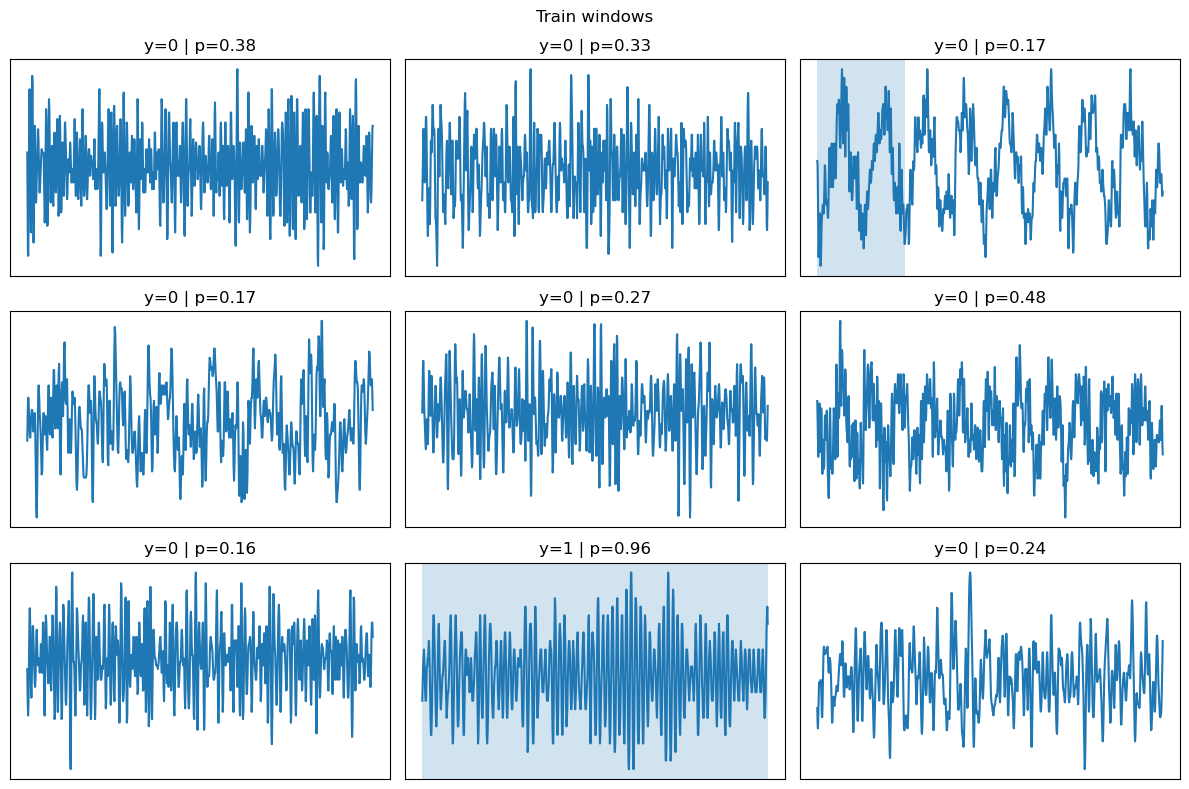

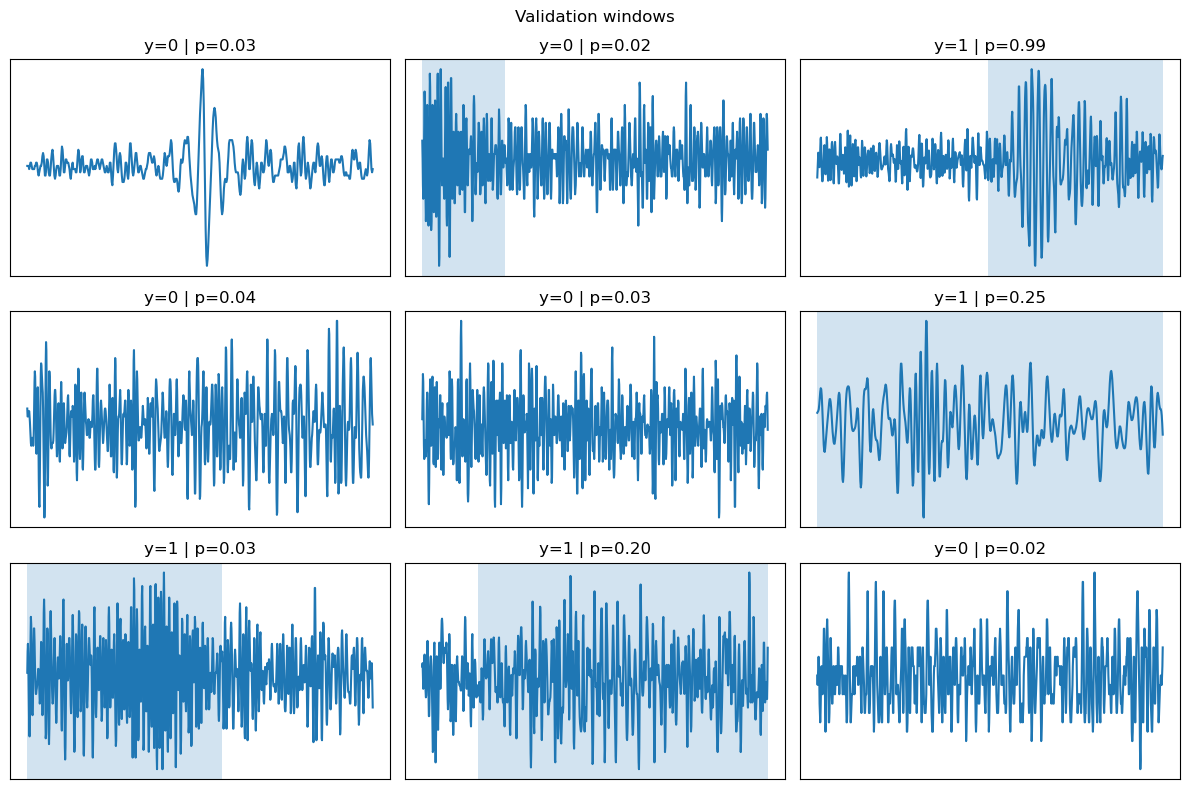

In [28]:
# Quick diagnostics: plot 3×3 grids of windows (train & valid/test)
import matplotlib.pyplot as plt
import random

@torch.no_grad()
def predict_window_probs(model, X, batch_size=256):
    model.eval()
    probs = []
    loader = DataLoader(TensorDataset(torch.from_numpy(X)), batch_size=batch_size, shuffle=False)
    for (xb,) in loader:
        xb = xb.to(device)
        p = torch.sigmoid(model(xb)).cpu().numpy()
        probs.append(p)
    return np.concatenate(probs, axis=0)

def load_window_segment(fp, s, e):
    df = load_and_preprocess_data(fp)
    z = df["z_m"].to_numpy()
    w = df["wake_label"].to_numpy().astype(int)
    t = df["t_s"].to_numpy()
    e = min(e, len(z))
    return t[s:e], z[s:e], w[s:e]

def plot_windows_grid(idx_triplets, probs, y_true, n=9, title=""):
    n = min(n, len(idx_triplets))
    sel = random.sample(range(len(idx_triplets)), n)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    axes = axes.ravel()

    for ax_i, j in enumerate(sel):
        fp, s, e = idx_triplets[j]
        t, z, w = load_window_segment(fp, s, e)
        ax = axes[ax_i]
        ax.plot(t, z)
        # shade wake
        if w.max() == 1:
            # find contiguous 1-runs
            wpad = np.pad(w, (1,1))
            dw = np.diff(wpad)
            starts = np.where(dw == 1)[0]
            ends   = np.where(dw == -1)[0]
            for a,b in zip(starts, ends):
                ax.axvspan(t[a], t[b-1], alpha=0.2)
        ax.set_title(f"y={int(y_true[j])} | p={float(probs[j]):.2f}")
        ax.set_xticks([])
        ax.set_yticks([])

    # hide any empty subplots
    for k in range(n, rows*cols):
        axes[k].axis('off')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

# Get probs
p_tr = predict_window_probs(model, X_tr) if X_tr is not None else None
p_va = predict_window_probs(model, X_va) if X_va is not None else None

# Plot 3×3 grids
if X_tr is not None:
    plot_windows_grid(idx_tr, p_tr, y_tr, n=9, title="Train windows")

if X_va is not None:
    plot_windows_grid(idx_va, p_va, y_va, n=9, title="Validation windows")


In [ ]:
def predict_probs(model, X):
    loader = DataLoader(TensorDataset(torch.from_numpy(X)), batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    probs = []
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            p = torch.sigmoid(model(xb)).cpu().numpy()
            probs.append(p)
    return np.concatenate(probs, axis=0)

In [ ]:
reports = {}

# Train (window-level)
ytr_true, ytr_prob = eval_on_loader(model, train_loader)
reports["train_window"] = window_metrics(ytr_true, ytr_prob, thr=DECISION_THR)

# Valid (window-level)
if val_loader is not None:
    yva_true, yva_prob = eval_on_loader(model, val_loader)
    reports["valid_window"] = window_metrics(yva_true, yva_prob, thr=DECISION_THR)

# Test (window-level, if labels exist you can build a labeled loader similarly.
# Here, we generated X_te without y_te; for window-level metrics you need y_te too.
# If you have y_te, create a loader like val_loader and eval similarly.)
if X_te is not None and y_te is not None:
    te_loader_labeled = DataLoader(
        TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te)),
        batch_size=BATCH_SIZE, shuffle=False
    )
    yte_true, yte_prob = eval_on_loader(model, te_loader_labeled)
    reports["test_window"] = window_metrics(yte_true, yte_prob, thr=DECISION_THR)
else:
    # still compute probs for file-level aggregation
    yte_prob = predict_probs(model, X_te) if X_te is not None else None

# File-level (max aggregation)
# Train
reports["train_file"] = file_level_metrics(dataset_splits, idx_tr, ytr_prob, thr=DECISION_THR)
# Valid
if X_va is not None:
    reports["valid_file"] = file_level_metrics(dataset_splits, idx_va, yva_prob, thr=DECISION_THR)
# Test (uses whatever we computed above)
if X_te is not None:
    # if we didn't compute yte_prob above (no labels), we still can aggregate predictions
    if yte_prob is None:
        yte_prob = predict_probs(model, X_te)
    reports["test_file"] = file_level_metrics(dataset_splits, idx_te, yte_prob, thr=DECISION_THR)

print("\n===== FINAL REPORTS =====")
for k, v in reports.items():
    print(f"[{k}] -> {v}")